In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import itertools
from os import listdir
import uproot
import awkward as ak
from sklearn.model_selection import train_test_split

import matplotlib as mpl

from datetime import datetime
import subprocess
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model, Sequential
import os
import tensorflow as tf
import sys
sys.path.append('/scratch/mjosef/Unfolding/omnifold')
from omnifold import DataLoader, MultiFold, MLP, SetStyle, HistRoutine, net, PET
#from omnifold.net import weighted_binary_crossentropy
#import energyflow as ef

from IPython.display import Image

os.environ['CUDA_VISIBLE_DEVICES']="2" #odslserv 0123 überprüfen
has_gpu=True

from pickle import dump

print(tf.config.list_physical_devices())

if has_gpu :
    os.environ['CUDA_VISIBLE_DEVICES']="3"
    physical_devices = tf.config.list_physical_devices('GPU') 
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

2025-07-11 10:42:42.142777: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-11 10:42:42.158682: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752223362.174751  610030 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752223362.179912  610030 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752223362.194881  610030 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Horovod not found, will continue with single only GPUs.
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
#truth_data = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/files_josef/truth_ttbar_enhanced.Nominal.root'
#herwig_data = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/files_josef/ttbar_enhanced_Herwig71_fast.Nominal.root'
#pythia_data = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/files_josef/ttbar_enhanced.Nominal.root'

#truth_file = uproot.open(truth_data)
#truth_tree = truth_file['NOSYS/physics'] # particle level quantities after particle level cuts

#herwig_file = uproot.open(herwig_data)
#herwig_tree = herwig_file['NOSYS/Whad_particle'] #check with Daniel if cuts are needed

#pythia_file = uproot.open(pythia_data)
#pythia_tree_matched = pythia_file['NOSYS/matched_Whad_particle'] # particle & reco level quantities after both cuts
#pythia_tree_reco = pythia_file['NOSYS/Whad_particle'] # particle & reco level quantities after reco cuts
#
#truth_array = truth_tree.arrays()
#herwig_array = herwig_tree.arrays()
#pythia_array_reco_cuts = pythia_tree_reco.arrays()
#pythia_array_matched_cuts = pythia_tree_matched.arrays()
#final_df.to_pickle("final_pythia_array")
#herwig_df.to_pickle("herwig_array")

pythia_df = pd.read_pickle('/scratch/mjosef/Unfolding/omnifold/final_pythia_array')
herwig_df = pd.read_pickle('/scratch/mjosef/Unfolding/omnifold/herwig_array_reco_cuts')
pythia_df.fillna(0.0, inplace=True)
herwig_df.fillna(0.0, inplace=True)

In [3]:
def data_shaper(df):

    particle_names = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6']

    # Build reco and truth arrays
    reco_pts  = [df[f'pt{p}']   for p in particle_names]
    reco_etas = [df[f'eta{p}']  for p in particle_names]
    reco_phis = [df[f'phi{p}']  for p in particle_names]
    
    # Masses: lepton = 0, b-jets = mb1–4, jets = mj1–6
    reco_masses = [np.zeros_like(df['ptl1'])] + \
                  [df[f'mb{i}'] for i in range(1, 5)] + \
                  [df[f'mj{i}'] for i in range(1, 7)]
    # Stack into (12 particles, n_events, 4)
    reco_features = np.stack([reco_pts, reco_etas, reco_phis, reco_masses], axis=-1)
    reco_features = reco_features.transpose(1, 0, 2)  # → (n_events, 12, 4)

    # Neutrino (reco): met, eta=0, phi=metphi, mass=0
    met_pt = df['met']
    met_phi = df['metphi']
    zeros = np.zeros_like(met_pt)
    neutrino_reco = np.stack([met_pt, zeros, met_phi, zeros], axis=-1)  # (n_events, 4)

    # Append neutrino
    reco_features = np.concatenate([reco_features, neutrino_reco[:, None, :]], axis=1)  # (n_events, 12, 4)
    truth_pts  = [df[f'truth_pt{p}']   for p in particle_names]
    truth_etas = [df[f'truth_eta{p}']  for p in particle_names]
    truth_phis = [df[f'truth_phi{p}']  for p in particle_names]
    
    truth_masses = [np.zeros_like(df['truth_ptl1'])] + \
                   [df[f'truth_mb{i}'] for i in range(1, 5)] + \
                   [df[f'truth_mj{i}'] for i in range(1, 7)]

    truth_features = np.stack([truth_pts, truth_etas, truth_phis, truth_masses], axis=-1)
    truth_features = truth_features.transpose(1, 0, 2)

    # Neutrino (truth): use 'truth_met' and 'truth_met_phi'
    truth_met_pt = df['truth_met']
    truth_met_phi = df['truth_metphi']
    zeros_truth = np.zeros_like(truth_met_pt)
    neutrino_truth = np.stack([truth_met_pt, zeros_truth, truth_met_phi, zeros_truth], axis=-1)

    truth_features = np.concatenate([truth_features, neutrino_truth[:, None, :]], axis=1)
    
    return reco_features, truth_features

In [4]:
pythia_reco, pythia_truth = data_shaper(pythia_df)
herwig_reco, herwig_truth = data_shaper(herwig_df)

pythia_weights = pythia_df['eventWeight'].to_numpy()
herwig_weights = herwig_df['eventWeight'].to_numpy()

pythia_pass_reco = pythia_df['pass_reco'].to_numpy()
pythia_pass_gen = pythia_df['pass_particle'].to_numpy()

In [5]:
#ids1 = ak.to_numpy(pythia_array_reco_cuts['event'])
#ids2 = ak.to_numpy(pythia_array_matched_cuts['event'])
#ids3 = ak.to_numpy(truth_array['event'])

# Get overlap
#reco_matched_ids = np.intersect1d(ids1, ids2)
#reco_truth_ids = np.intersect1d(ids1, ids3)
#matched_truth = np.intersect1d(ids2, ids3)
#print(len(reco_matched_ids), len(reco_truth_ids), len(matched_truth))
#mask = ~np.isin(reco_truth_ids, matched_truth)
#filtered_array = truth_array[mask]
#len(filtered_array)

In [6]:
all_indices_pythia = np.arange(len(pythia_reco))
np.random.seed(42)  # reproducibility
np.random.shuffle(all_indices_pythia)

# First random sample
random_indices_pythia_1 = all_indices_pythia[:100_000]
# Second, independent (non-overlapping) sample
random_indices_pythia_2 = all_indices_pythia[100_000:200_000]

# First Pythia sample
pythia_reco_train    = pythia_reco[random_indices_pythia_1]
pythia_truth_train   = pythia_truth[random_indices_pythia_1]
pythia_weights_train = pythia_weights[random_indices_pythia_1]
pythia_pass_reco_train = pythia_pass_reco[random_indices_pythia_1]
pythia_pass_gen_train = pythia_pass_gen[random_indices_pythia_1]

# Second Pythia sample
pythia_reco_test    = pythia_reco[random_indices_pythia_2]
pythia_truth_test   = pythia_truth[random_indices_pythia_2]
pythia_weights_test = pythia_weights[random_indices_pythia_2]
pythia_pass_reco_test = pythia_pass_reco[random_indices_pythia_2]
pythia_pass_gen_test = pythia_pass_gen[random_indices_pythia_2]

# First Herwig sample
random_indices_herwig = np.random.choice(len(herwig_reco), size=100_000, replace=False)
herwig_reco_train   = herwig_reco[random_indices_herwig]
herwig_truth_train   = herwig_truth[random_indices_herwig]
herwig_weights_train = herwig_weights[random_indices_herwig]

In [7]:
herwig_loader = DataLoader(reco = herwig_reco_train, gen = herwig_truth_train, weight = herwig_weights_train,
                           normalize=True, normalization_factor = np.sum(herwig_weights_train))

pythia_loader = DataLoader(reco = pythia_reco_train, gen = pythia_truth_train, weight = pythia_weights_train,
                           pass_reco = pythia_pass_reco_train, pass_gen = pythia_pass_gen_train,
                           normalize=True, normalization_factor = np.sum(pythia_weights_train))

INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...
INFO: Normalizing sum of weights to 16579.306640625 ...
INFO: Normalizing sum of weights to 8396.0419921875 ...


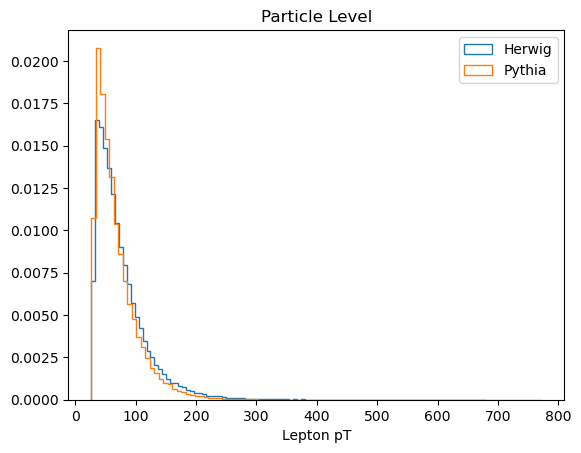

In [8]:
plt.hist(herwig_loader.gen[:,0,0], weights=herwig_loader.weight, bins=100, histtype='step',density=True, label="Herwig")
plt.hist(pythia_loader.gen[:,0,0], weights=pythia_loader.weight, bins=100, histtype='step',density=True, label="Pythia")
#plt.yscale('log')
plt.title("Particle Level")
plt.xlabel("Lepton pT")
plt.legend()
plt.show()

(<Figure size 900x900 with 2 Axes>,
 <Axes: ylabel='Normalized number of events'>)

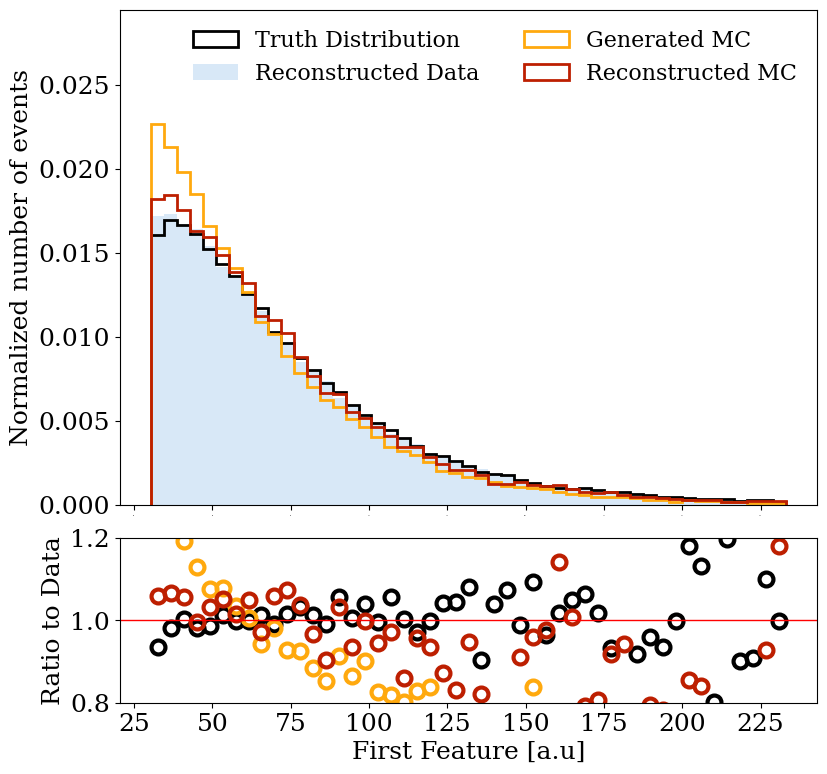

In [9]:
SetStyle()
data_dict = {
    'Truth Distribution': herwig_loader.gen[:,0,0],
    'Reconstructed Data': herwig_loader.reco[:,0,0],
    'Generated MC': pythia_loader.gen[:,0,0],
    'Reconstructed MC': pythia_loader.reco[:,0,0],
}
weight_dict = {
        'Truth Distribution': herwig_loader.weight,
        'Reconstructed Data': herwig_loader.weight,
        'Generated MC': pythia_loader.weight,
        'Reconstructed MC': pythia_loader.weight,
}
HistRoutine(data_dict,'First Feature [a.u]', reference_name = 'Reconstructed Data', weights=weight_dict,plot_ratio=True)

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

class MaskedAveragePooling(layers.Layer):
    def call(self, x, mask):
        # x: (batch, seq_len, features)
        # mask: (batch, seq_len), dtype bool
        mask = tf.cast(mask, tf.float32)[..., tf.newaxis]  # (batch, seq_len, 1)
        x = x * mask
        return tf.reduce_sum(x, axis=1) / tf.reduce_sum(mask, axis=1)

class ParticleMaskLayer(layers.Layer):
    def call(self, x):
        return tf.reduce_any(tf.not_equal(x, 0), axis=-1)  # shape: (batch, seq)

def build_transformer_model(input_shape=(12, 4),
                            num_heads=4,
                            ff_dim=64,
                            num_transformer_blocks=2,
                            dropout_rate=0.1):

    inputs = Input(shape=input_shape)

    # Get attention mask: True where not padded
    mask = ParticleMaskLayer()(inputs)  # shape: (batch, 11)

    # Learned positional embedding
    positions = tf.range(start=0, limit=input_shape[0], delta=1)
    pos_embed = layers.Embedding(input_dim=input_shape[0], output_dim=input_shape[1])(positions)
    x = inputs + pos_embed  # broadcasting position embedding

    for _ in range(num_transformer_blocks):
        attn_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=input_shape[1]
        )(x, x, attention_mask=mask[:, tf.newaxis, :])  # shape: (batch, 1, 11)

        attn_output = layers.Dropout(dropout_rate)(attn_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)

        ff_output = layers.Dense(ff_dim, activation='relu')(x)
        ff_output = layers.Dense(input_shape[1])(ff_output)
        ff_output = layers.Dropout(dropout_rate)(ff_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ff_output)

    # Use masked average pooling instead of GlobalAveragePooling1D
    x = MaskedAveragePooling()(x, mask)

    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    return Model(inputs=inputs, outputs=outputs)

In [11]:
model1 = build_transformer_model()
model2 = build_transformer_model()

I0000 00:00:1752223405.307558  610030 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 133837 MB memory:  -> device: 0, name: NVIDIA H200, pci bus id: 0000:43:00.0, compute capability: 9.0


In [12]:
omnifold = MultiFold(
    "WWbb_transformer",
    model1,
    model2,
    herwig_loader,
    pythia_loader,
    batch_size = 128,
    niter = 5,  #Number of Iterations                                                                                                                                                                                                  
    epochs=100,     
    weights_folder = 'weights_transformer_acceptance_corrections',
    verbose = True,
    lr = 5e-5,
)

1562 training steps at reco and 1562 steps at gen


In [13]:
%%time
omnifold.Unfold()

ITERATION: 1
RUNNING STEP 1A
Creating cached data from step 1
################################################################################
Train events used: 119860, Test events used: 29965
################################################################################
Epoch 1/100


I0000 00:00:1752223411.306972  610756 service.cc:152] XLA service 0x7f06c8002760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752223411.307003  610756 service.cc:160]   StreamExecutor device (0): NVIDIA H200, Compute Capability 9.0
2025-07-11 10:43:31.412512: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752223412.165760  610756 cuda_dnn.cc:529] Loaded cuDNN version 90501


 33/749 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0707   

I0000 00:00:1752223419.538616  610756 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


749/749 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.0680 - val_loss: 0.0629 - learning_rate: 5.0000e-05
Epoch 2/100
749/749 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0627 - val_loss: 0.0618 - learning_rate: 5.0000e-05
Epoch 3/100
749/749 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0624 - val_loss: 0.0615 - learning_rate: 5.0000e-05
Epoch 4/100
749/749 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0620 - val_loss: 0.0613 - learning_rate: 5.0000e-05
Epoch 5/100
749/749 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0616 - val_loss: 0.0613 - learning_rate: 5.0000e-05
Epoch 6/100
749/749 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0615 - val_loss: 0.0612 - learning_rate: 5.0000e-05
Epoch 7/100
749/749 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0615 - val_loss: 0.0612 - learning_rate: 5.0000e-05
Epoch 8/100
749/749 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0616 - val_loss: 0.0612 - learning_rate: 5.0000e-05
Epoch 9/100
749/749 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0615 - val_loss: 0.0612 - le

KeyboardInterrupt: 

In [14]:
unfolded_weights  = omnifold.reweight(pythia_truth_test,omnifold.model2,batch_size=1000)

In [67]:
np.save("weights_transformer/unfolded_weights.npy", unfolded_weights)

In [68]:
abc = np.load("weights_transformer/unfolded_weights.npy")

In [70]:
print(unfolded_weights.shape, abc.shape)

(1000000,) (1000000,)


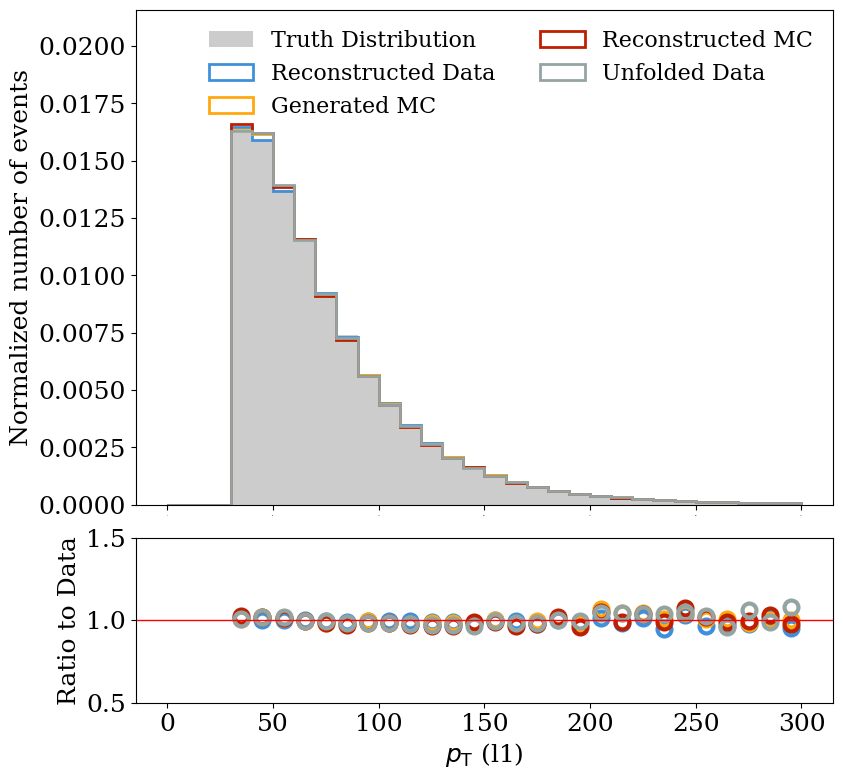

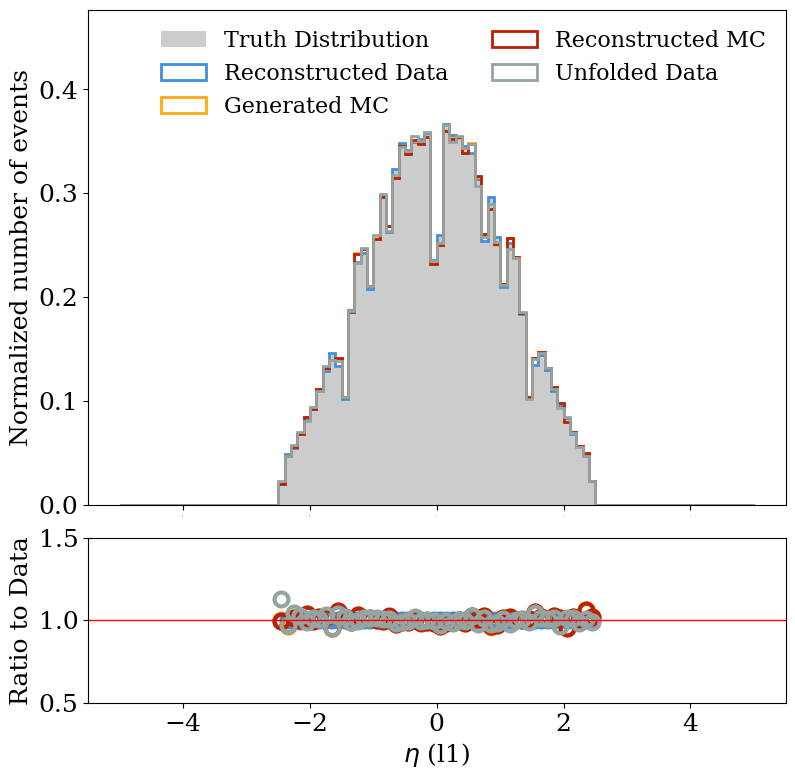

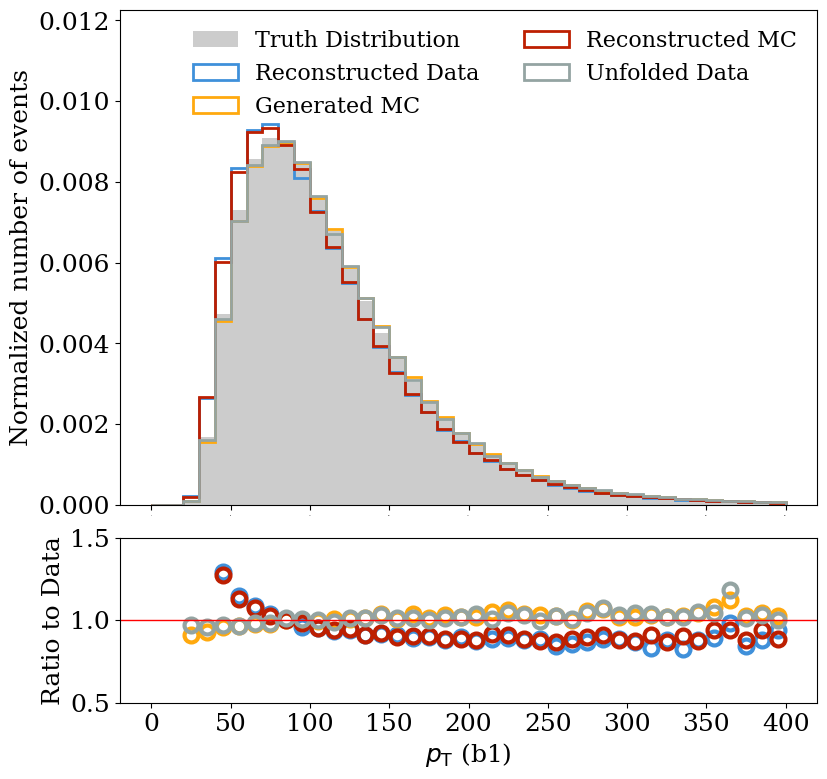

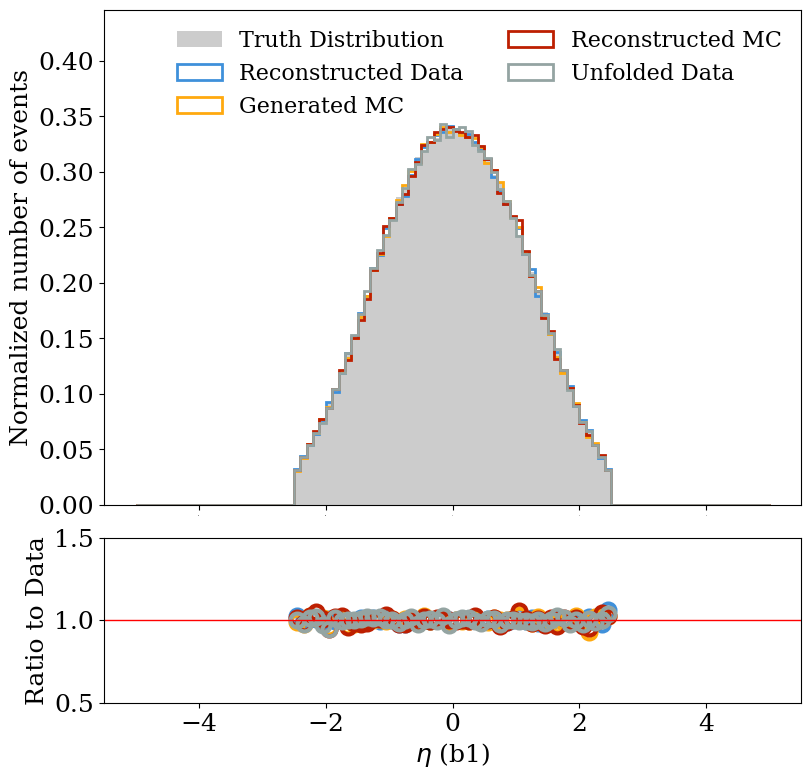

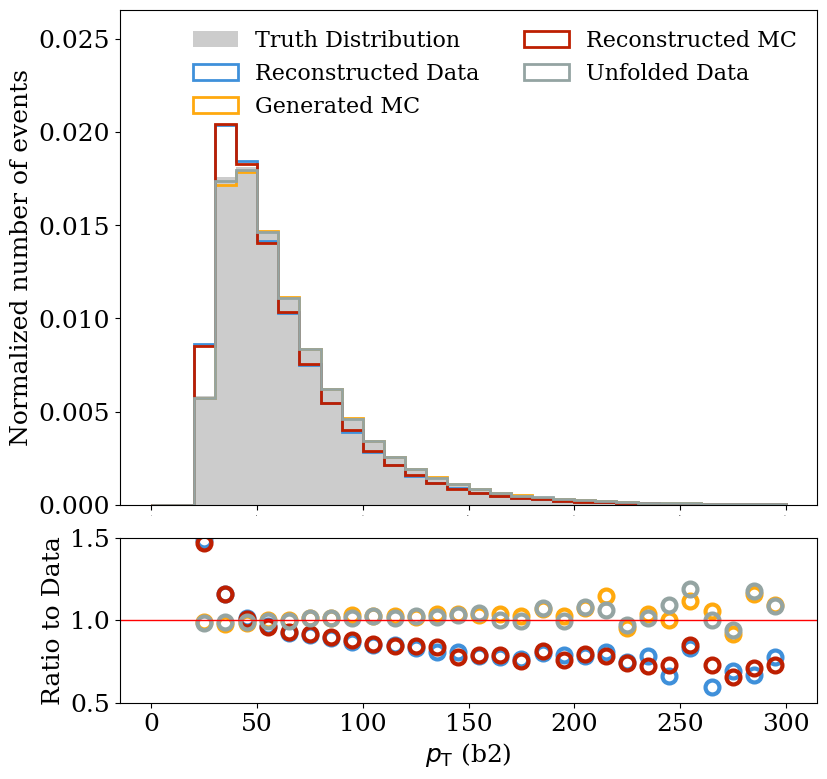

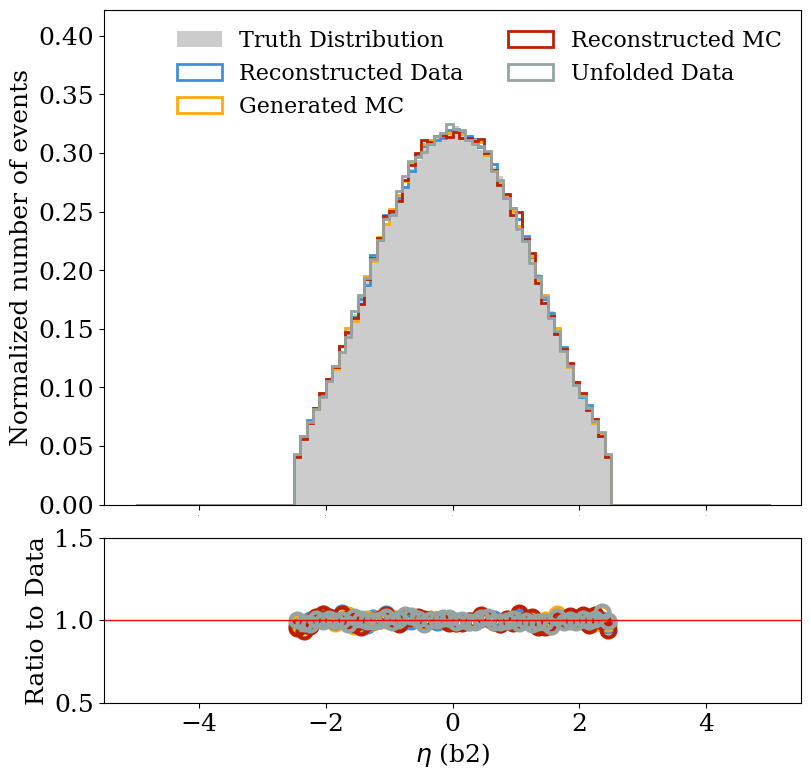

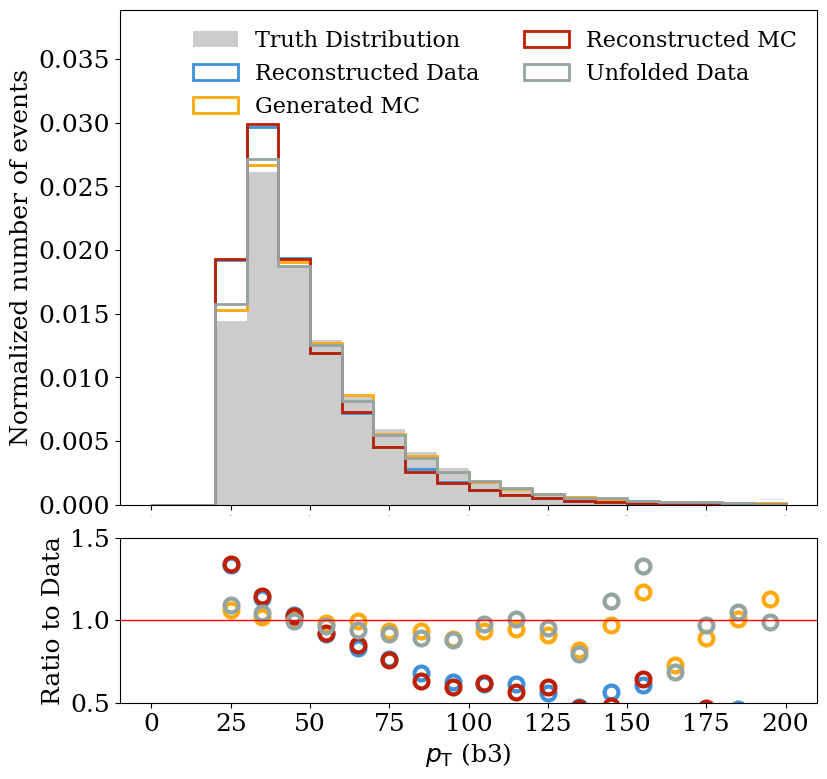

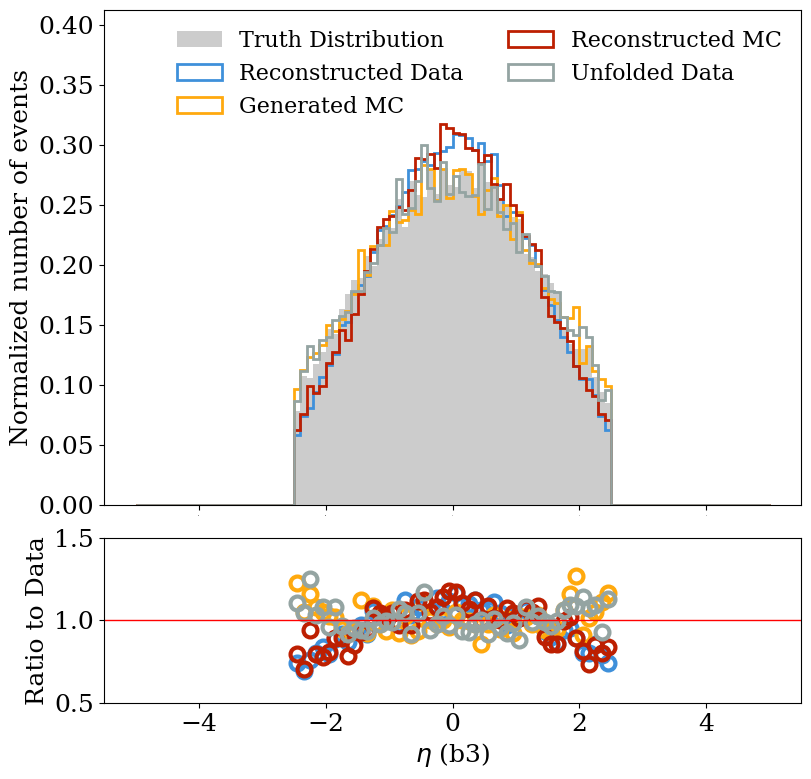

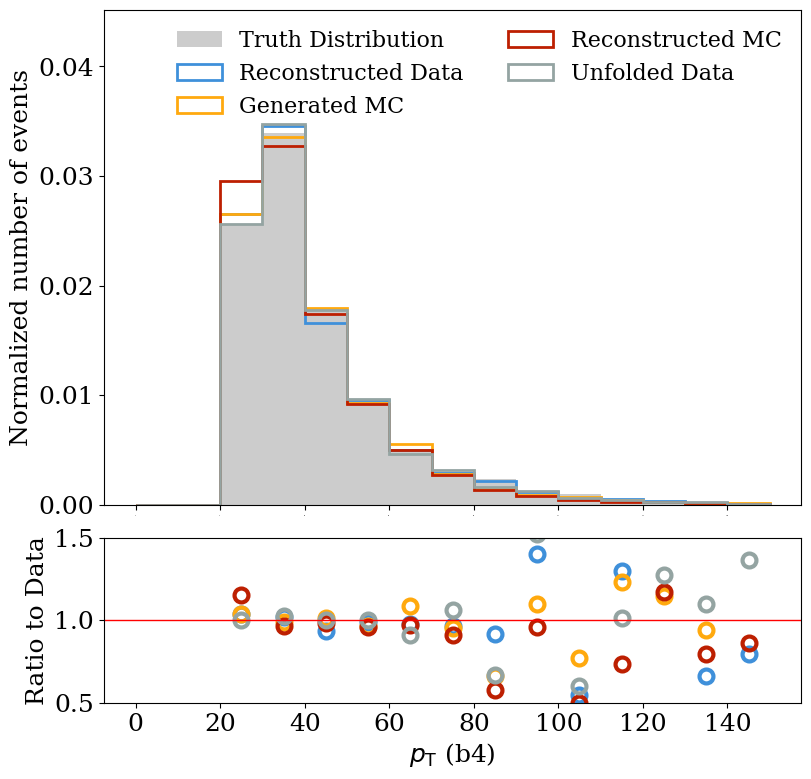

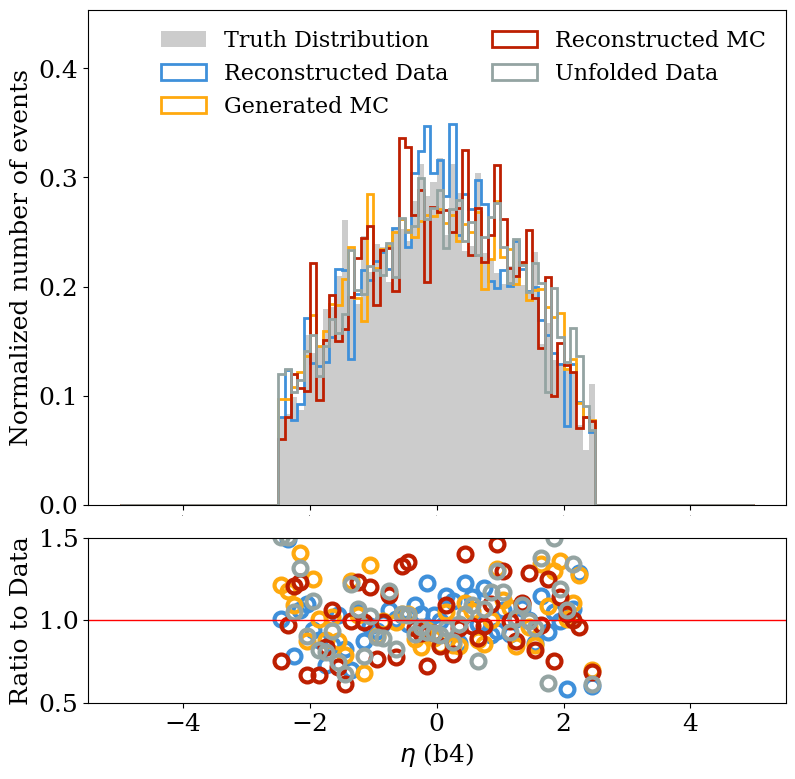

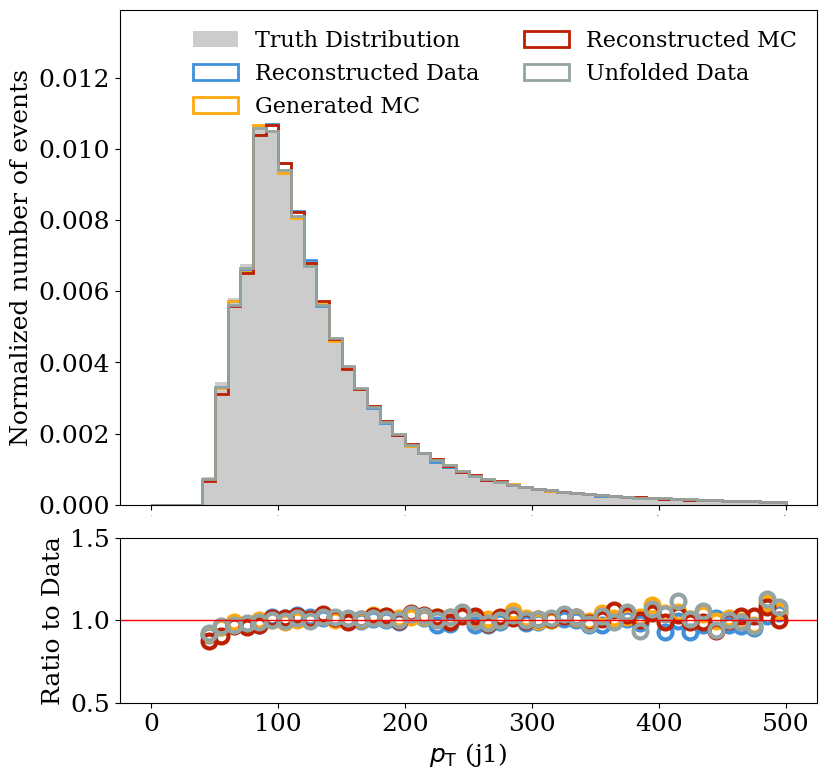

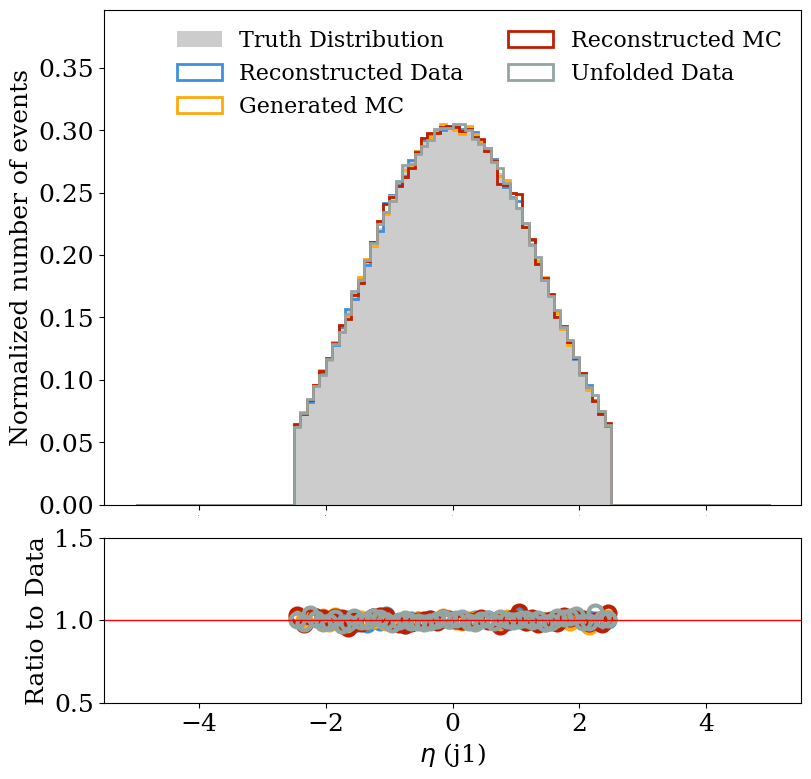

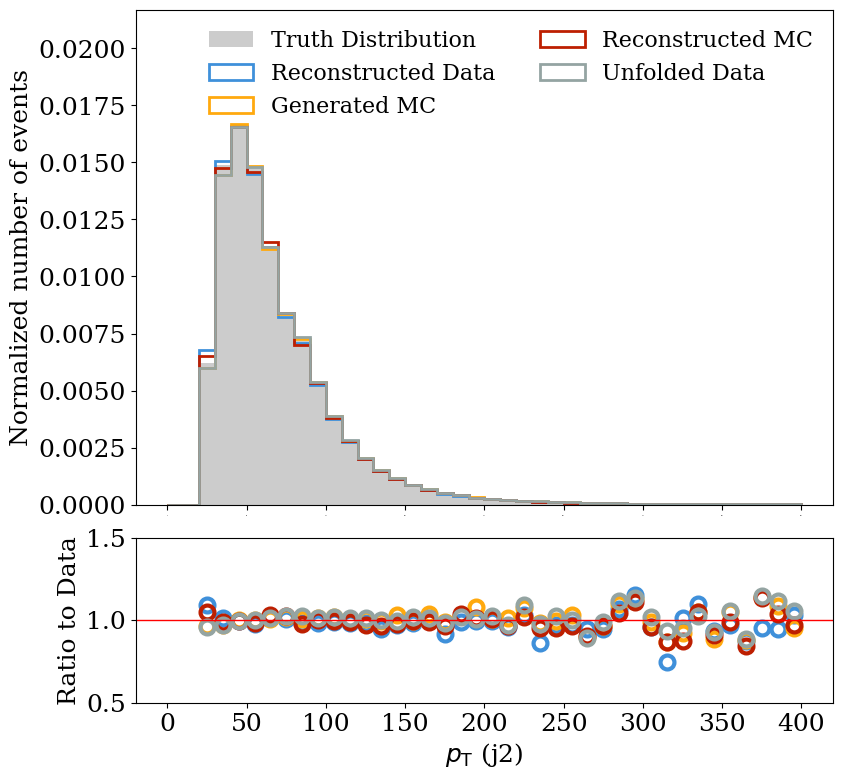

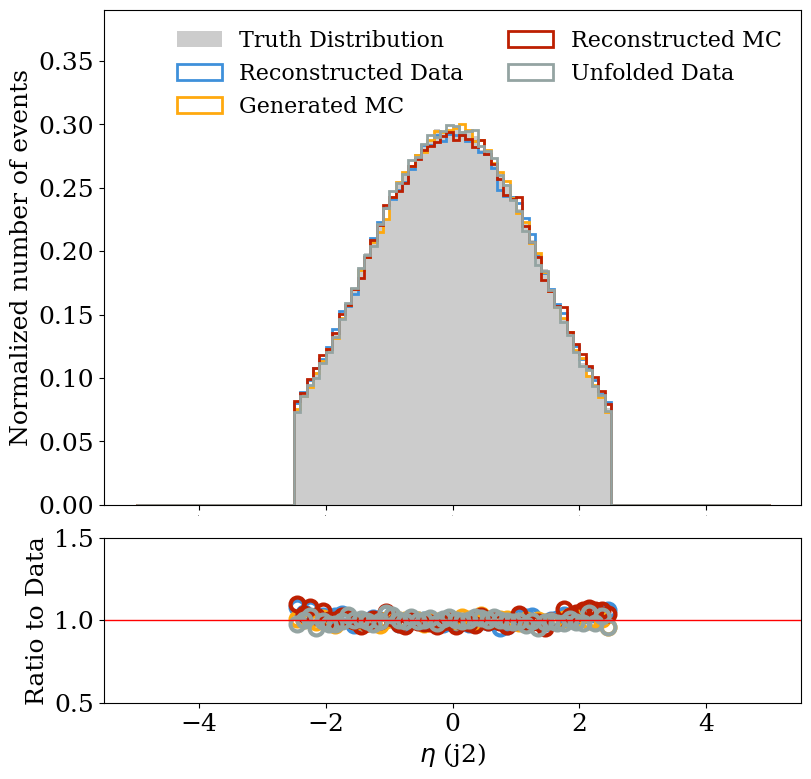

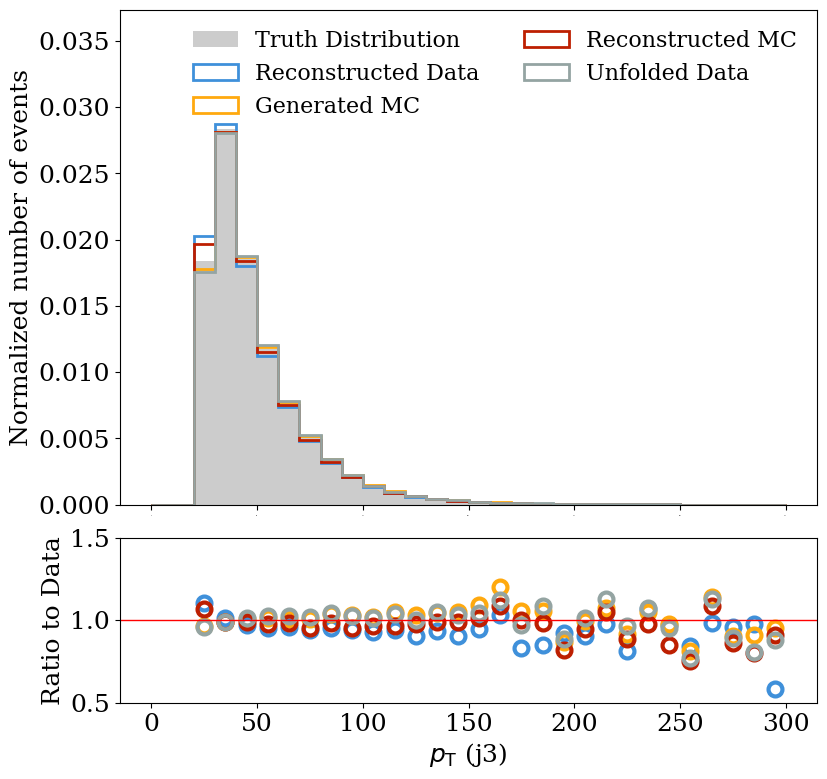

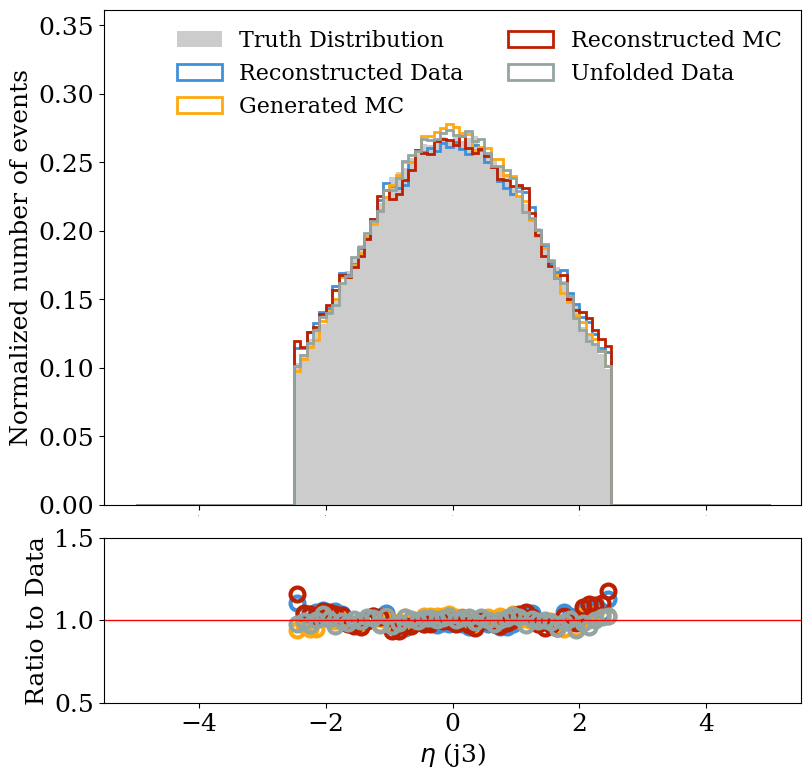

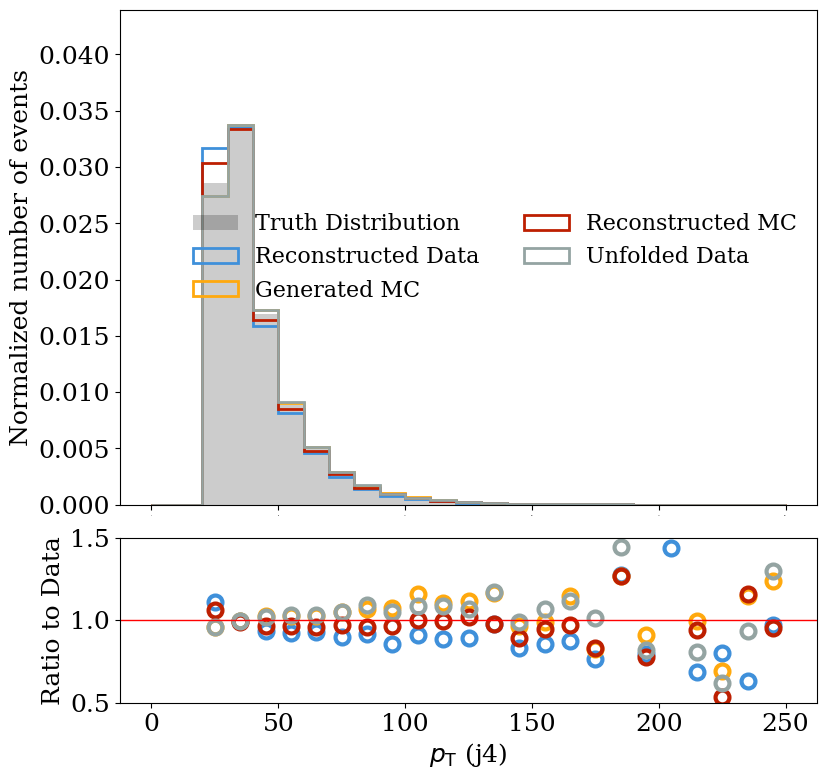

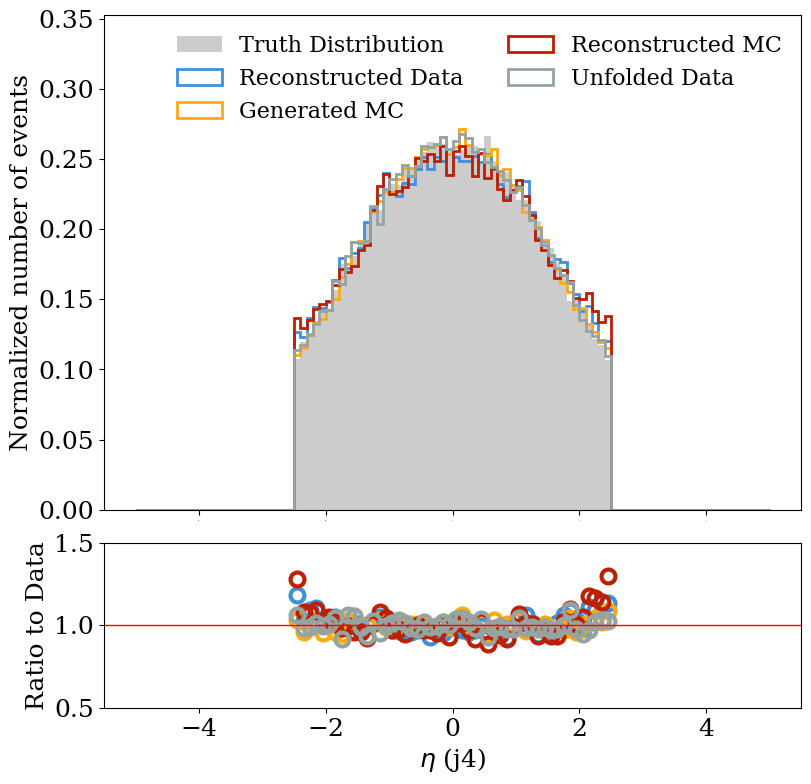

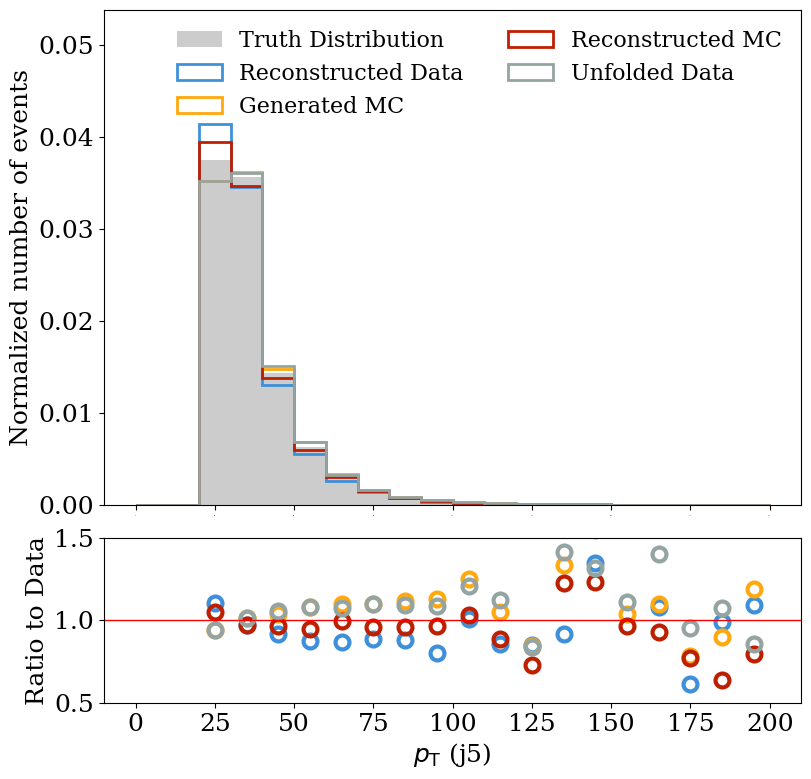

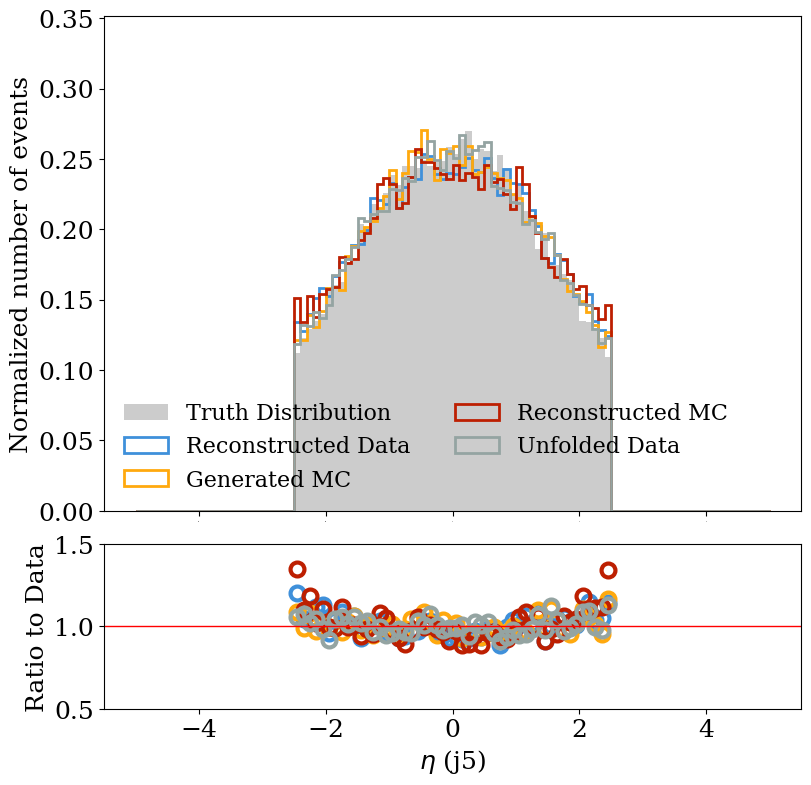

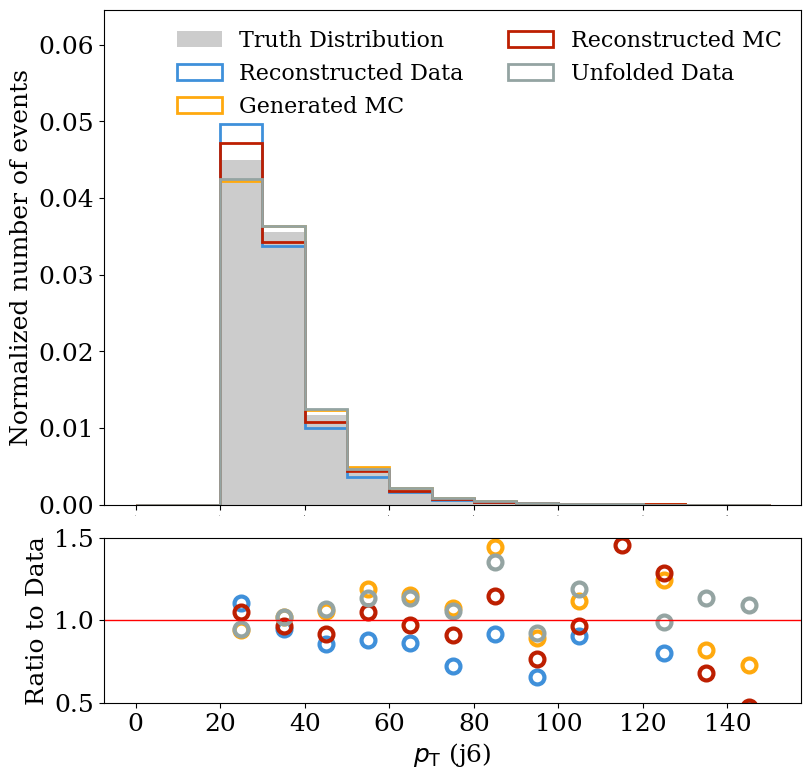

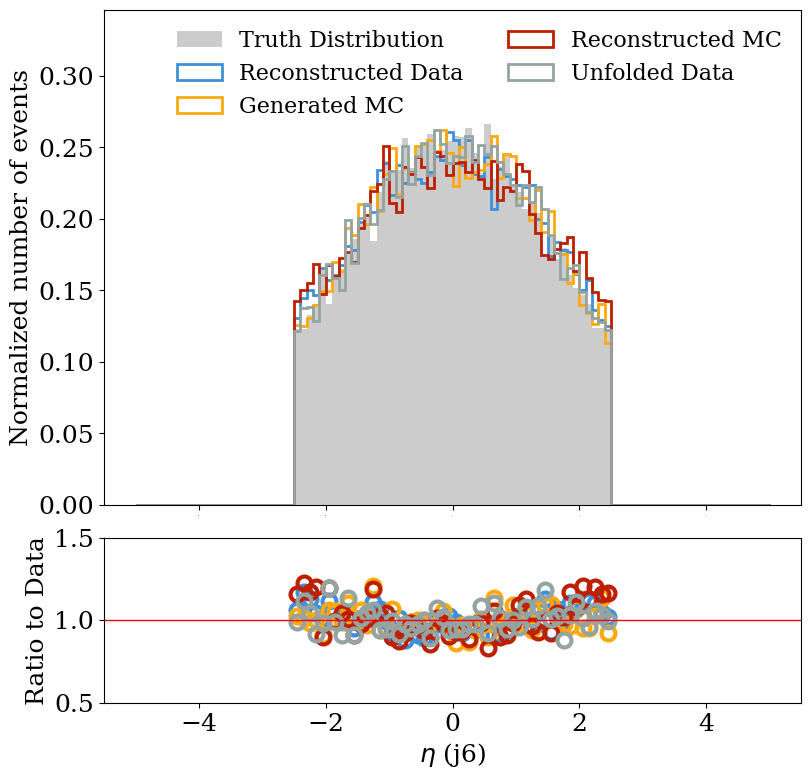

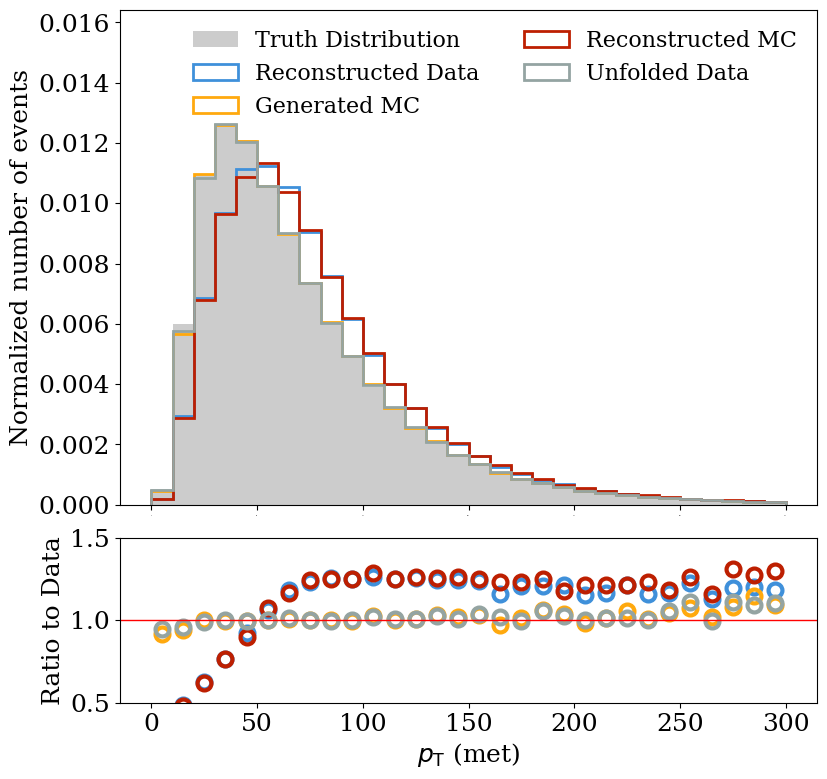

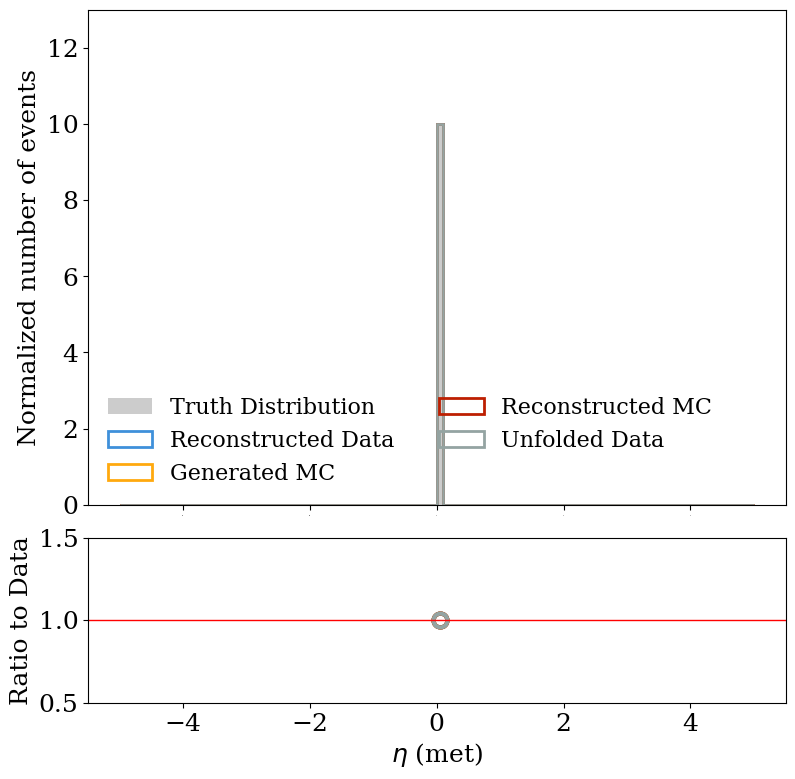

In [64]:
particles = ['l1', 'b1', 'b2', 'b3', 'b4', 'j1', 'j2', 'j3', 'j4', 'j5', 'j6', 'met']

pt_binning = {
    'l1': np.linspace(0, 300, 31),
    'b1': np.linspace(0, 400, 41),
    'b2': np.linspace(0, 300, 31),
    'b3': np.linspace(0, 200, 21),
    'b4': np.linspace(0, 150, 16),
    'j1': np.linspace(0, 500, 51),
    'j2': np.linspace(0, 400, 41),
    'j3': np.linspace(0, 300, 31),
    'j4': np.linspace(0, 250, 26),
    'j5': np.linspace(0, 200, 21),
    'j6': np.linspace(0, 150, 16),
    'met': np.linspace(0, 300, 31),
}
default_binning = [
    None,  # placeholder for pt, unused
    np.linspace(-5, 5, 101),     # eta
]

labels = [
    r"$p_\mathrm{T}$",
    r"$\eta$",
]

for i, pname in enumerate(particles):
    for obs_index in range(2):  # 0: pT, 1: eta
        if obs_index == 0:
            bins = pt_binning[pname]
        else:
            bins = default_binning[obs_index]
        data_dict = {
            'Truth Distribution': herwig_loader.gen[:, i, obs_index][herwig_loader.gen[:, i, 0]!=0],
            'Reconstructed Data': herwig_loader.reco[:, i, obs_index][herwig_loader.reco[:, i, 0]!=0],
            'Generated MC': pythia_loader.gen[:, i, obs_index][pythia_loader.gen[:, i, 0]!=0],
            'Reconstructed MC': pythia_loader.reco[:, i, obs_index][pythia_loader.reco[:, i, 0]!=0],
            'Unfolded Data': pythia_truth_test[:, i, obs_index][pythia_truth_test[:, i, 0]!=0],
        }

        weight_dict = {
            'Truth Distribution': herwig_loader.weight[herwig_loader.gen[:, i, 0]!=0],
            'Reconstructed Data': herwig_loader.weight[herwig_loader.reco[:, i, 0]!=0],
            'Generated MC': pythia_loader.weight[pythia_loader.gen[:, i, 0]!=0],
            'Reconstructed MC': pythia_loader.weight[pythia_loader.reco[:, i, 0]!=0],
            'Unfolded Data': unfolded_weights[pythia_truth_test[:, i, 0]!=0]*pythia_weights_test[pythia_truth_test[:, i, 0]!=0],
        }

        fig, _ = HistRoutine(
            data_dict,
            f"{labels[obs_index]} ({pname})",
            reference_name='Truth Distribution',
            weights=weight_dict,
            plot_ratio=True,
            binning=bins
        )